# Demonstration of using the `fluorescent_protein_production_rate` module

## Setup

This is a quick demo of some of the ways this package can be used.

In [1]:
import os
import json

import pandas as pd
from fluorescent_protein_production_rate import (
    CellCycle,
    FluorescentProteinProductionRateExperiment,
    get_version
)

### Checking the module and source code version

Calling `get_version()` in analysis notebooks will help to clarify exactly which version of the code is being used, which is helpful for reproducibility. `get_version()` returns a dictionary with two keys:
- `version` : The version number is a module global value which should be the same as the one in the setup.py file and on any release version. This needs to be kept up to date manually, so it is possible that it might be out of sync with the actual code changes. 
- `SHA256` : The SHA256 hash of the `fluorescent_protein_production_rate.py` source code file itself. Hash values for different notebooks will only match if they are running code from _identical_ `fluorescent_protein_production_rate.py` files. In general, any change to the source code file will result in a completely different SHA256 hash, so this serves as a fallback check in case the version number isn't kept up to date.

In [2]:
print(
    f"fluorescent_protein_production_rate.py version: {get_version()['version']}\n"
    f"fluorescent_protein_production_rate.py SHA256: {get_version()['SHA256']}"
)

fluorescent_protein_production_rate.py version: 0.1.0
fluorescent_protein_production_rate.py SHA256: 100f049669902a4ddb0a649b6933f081b948563497f6cf654f823c3a423e6db7


### Loading demo data and requirements

Load up some test data.

In [3]:
test_data_dir_path = "Demo_data"

with open(os.path.join(test_data_dir_path, "cycle_ids.json"), "rb") as f:
    cell_ids = json.load(f)["cell_ids"]

old_cell_test_data = {}
for cell_id in cell_ids:
    temp_cell_data = pd.read_csv(
        os.path.join(test_data_dir_path, "cell_traces", f"{cell_id}_mother_trace.csv"),
        index_col=False
    )
    temp_previous_bud_data = pd.read_csv(
        os.path.join(test_data_dir_path, "previous_bud_traces", f"{cell_id}_previous_bud_trace.csv"),
        index_col=False
    )
    temp_current_bud_dtata = pd.read_csv(
        os.path.join(test_data_dir_path, "current_bud_traces", f"{cell_id}_bud_trace.csv"),
        index_col=False
    )
    with open(
        os.path.join(test_data_dir_path, "cycle_events", f"{cell_id}_events_log.json"), "r"
    ) as f:
        temp_cycle_events = json.load(f)
    
    old_cell_test_data[cell_id] = {
        "mother_data": temp_cell_data,
        "previous_bud_data": temp_previous_bud_data,
        "current_bud_data": temp_current_bud_dtata,
        "cycle_events": temp_cycle_events
    }

"Mother" data or "Cell" data is data for the main cell tracked for a given cycle. It should have at least the following columns:
- **TimeID**: The imaging frame number.
- **Volume**: The volume of the cell. Up to you how you calculate this, but it should be the volume _only_ for that cell, no buds.
- **Concentration**: The concentration of the fluorescent protein in the cell.
- **Interpolate**: A boolean indicating whether the data for a given frame should be deleted and estimated using linear interpolation.

In [4]:
old_cell_test_data["01_01_01"]["mother_data"].head()

,TimeID,Volume,Concentration,Interpolate
0,1,50.224642,202.121662,False
1,2,48.719748,211.432678,False
2,3,48.213080,211.605422,False
3,4,48.793960,203.664179,False
4,5,47.957459,203.236006,False


"Previous" bud data is data for the bud which was formed in the cycle _before_ the cycle a given data set is primarily concerned with. "Current" bud data is data for the bud which was formed in the cycle a given data set is primarily concerned with. These should have the same columns as "Mother" data other than "Concentration", which is not required.

In [5]:
display(old_cell_test_data["01_01_01"]["previous_bud_data"].head())
display(old_cell_test_data["01_01_01"]["current_bud_data"].head())

,TimeID,Volume,Interpolate
0,2,6.451261,False
1,3,7.855590,False
2,4,11.145742,False
3,5,12.971846,False
4,6,16.742561,False


,TimeID,Volume,Interpolate
0,17,2.948908,False
1,18,4.768892,False
2,19,8.831243,False
3,20,9.796345,False
4,21,12.463469,False


"Cycle events" are the event names and TimeIDs corresponding to the main cell cycle events we're concerned with.

In [6]:
old_cell_test_data["01_01_01"]["cycle_events"]

{'Bud_0': 1,
 'Mitotic_exit_0': 8,
 'START': 10,
 'Bud_1': 12,
 'Mitotic_exit_1': 24}

## The `CellCycle` class

Each instance of a `CellCycle` object represents data for a single cell cycle. It contains methods for validating the input data has the correct structure, merging mother and bud data, calculating various quantities, and plotting the results. Generally, you will not need to create instances of this class directly, but rather use the `FluorescentProteinProductionRateExperiment` class, which will create instances of `CellCycle` for you. Nonetheless, here is a tour of the class.

### Creating a `CellCycle` instance

In addition to the input data we've seen already, this has a few additional parameters:
- `cycle_end_event`: The name of the event that marks the end of the cell cycle. For example, if your cycle events data contains "Mitotic_exit_0" and "Mitotic_exit_1", you would set this to "Mitotic_exit".
- `min_extra_data_points`: Minimum number of extra data points either side of the cycle of interest for smoothing.
- `max_extra_data_points`: Maximum number of extra data points either side of the cycle of interest for smoothing. Additional points will be clipped off.

An error will be raised if the input data does not have enough data points to satisfy the `min_extra_data_points` and you will only be warned if it does not exceed the `max_extra_data_points`. Any additional points above the maximum will be clipped off and ignored when calculating the results.

In [ ]:
cc = CellCycle(
    cycle_id="01_01_01",
    mother_data=old_cell_test_data["01_01_01"]["mother_data"],
    previous_bud_data=old_cell_test_data["01_01_01"]["previous_bud_data"],
    current_bud_data=old_cell_test_data["01_01_01"]["current_bud_data"],
    cycle_events=old_cell_test_data["01_01_01"]["cycle_events"],
    cycle_end_event="Mitotic_exit",
    min_extra_data_points=3,
    max_extra_data_points=8
)

### Calculating values for a single cell cycle

The analysis for a given single cycle needs to be performed in a specific order. We start with merging the mother and bud data together. This method takes care of any necessary interpolation and calculates a "Total volume" column by combining the mother and bud data. This merged data is then available from the `.cycle_data` property.

In [8]:
cc.merge_cycle_data(
    image_capture_interval=6,  # Image capture interval in minutes (or other units)
)
cc.cycle_data.head()

,TimeID,Volume,Concentration,Previous bud volume,Current bud volume,Total volume,Time
1,1,50.224642,202.121662,-19.543974,0.0,30.680668,0
2,2,48.719748,211.432678,-13.092713,0.0,35.627035,6
3,3,48.213080,211.605422,-11.688383,0.0,36.524697,12
4,4,48.793960,203.664179,-8.398231,0.0,40.395729,18
5,5,47.957459,203.236006,-6.572128,0.0,41.385331,24


You can also easily access individual columns from `.cycle_data` in other ways too e.g.

In [9]:
# The following are equivalent
print(cc["TimeID"])
print(cc.time_id)

# As are these
print(cc["Total volume"])
print(cc.total_volume)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
[30.68066819 35.62703461 36.52469654 40.39572931 41.385331   45.41166735
 48.48535553 48.60033363 48.53294856 49.90322331 51.08669897 50.34297508
 52.07097251 52.85800011 51.6451024  51.95988579 54.23285321 52.15826271
 55.85467319 57.82501308 62.41919022 64.34735318 67.2874357  67.62066653
 69.21321106 70.30098961 70.9965466  68.92759421 70.70278674 69.71657797
 69.89919247 70.61930415]
[30.68066819 35.62703461 36.52469654 40.39572931 41.385331   45.41166735
 48.48535553 48.60033363 48.53294856 49.90322331 51.08669897 50.34297508
 52.07097251 52.85800011 51.6451024  51.95988579 54.23285321 52.15826271
 55.85467319 57.82501308 62.41919022 64.34735318 67.2874357  67.62066653
 69.21321106 70.30098961 70.9965466  68.92759421 70.70278674 69.71657797
 69.89919247 70.61930415]


Next we calculate the abundance by multiplying the concentration by the total volume.

In [10]:
cc.calculate_abundance()

# Can now access the new abundance column
print(cc["Abundance"])
print(cc.abundance)

[ 6201.22763753  7532.71932931  7728.82381429  8227.1630499
  8410.98938137  8803.95514069  8906.8830171   8633.31941634
  9272.9947494   9573.9518755   9639.94299068  9744.81631407
 10368.0001108  10639.34548229 10790.46797716 11184.6675096
 11808.97002461 11237.93880184 11959.69319908 12508.71024183
 12788.1315955  12358.5106444  12632.89773554 13250.19556922
 13286.1134802  14097.18824901 14426.88464423 14702.47944567
 15244.79404999 15654.45315086 15933.91356155 16342.12029274]
[ 6201.22763753  7532.71932931  7728.82381429  8227.1630499
  8410.98938137  8803.95514069  8906.8830171   8633.31941634
  9272.9947494   9573.9518755   9639.94299068  9744.81631407
 10368.0001108  10639.34548229 10790.46797716 11184.6675096
 11808.97002461 11237.93880184 11959.69319908 12508.71024183
 12788.1315955  12358.5106444  12632.89773554 13250.19556922
 13286.1134802  14097.18824901 14426.88464423 14702.47944567
 15244.79404999 15654.45315086 15933.91356155 16342.12029274]


Next, smooth the abundance using a Gaussian process relying mainly on a Rational Quadratic kernel. You can specify various hyperparameters for the kernels and GP, or leave the defaults. Note that we often see warnings during the GP fitting process. You may wish to investigate some of them, but generally the fits produced look decent in any case.

In [ ]:
cc.calculate_smoothed_abundance()

# Can now access the new smoothed abundance column and the GP if required.
print(cc.smoothed_abundance)
print(cc.abundance_gp.kernel_)

Now calculate the production rate. You can optionally specify to correct for the fluorophore maturation time.

In [12]:
cc.calculate_production_rate(
    apply_maturation_correction=True,
    maturation_time=6 # Should be correct for sfGFP
)

cc.production_rate

array([54.7786341 , 52.31174233, 50.66417309, 49.00866962, 47.39224725,
       45.86089643, 44.45853715, 43.2259995 , 42.20005809, 41.41254589,
       40.88957237, 40.65086756, 40.70927077, 41.0703792 , 41.73236649,
       42.68597785, 43.91470246, 45.3951196 , 47.09740952, 48.98601625,
       51.02044428, 53.15616789, 55.34562893, 57.53929606, 59.68675708,
       61.73781576, 63.64356435, 65.3574046 , 66.83599199, 68.04008075,
       68.93525104, 68.86529607])

We're generally aiming for the volume specific production rate, so we now have to smooth the volume using a GP and then divide the production rate by the volume to get the volume specific production rate. Again, you can specify a bunch of values for the volume smoothing process if you wish and warnings are common.

In [13]:
cc.calculate_smoothed_volume()
cc.calculate_volume_specific_production_rate()

print(cc.smoothed_volume)
print(cc.volume_gp.kernel_)
print(cc["Specific production rate"])

[31.62546129 34.27045305 37.15519422 40.02644771 42.68140601 44.99062672
 46.90009515 48.41465648 49.57148011 50.4154602  50.98695306 51.32629166
 51.49133962 51.57737361 51.72601364 52.113286   52.91523416 54.25955937
 56.17935507 58.58667884 61.27837515 63.97598249 66.38967657 68.28754105
 69.54928144 70.18853497 70.33818484 70.20474801 70.00690309 69.91675637
 70.01987106 70.30291118]
13.8**2 * RBF(length_scale=36.2) + WhiteKernel(noise_level=1.02)
[1.73210546 1.5264386  1.36358251 1.22440717 1.11037221 1.01934336
 0.9479413  0.8928288  0.85129712 0.82142553 0.80196148 0.79200866
 0.79060423 0.79628675 0.80679649 0.81909972 0.82990661 0.83662898
 0.83834016 0.83612892 0.83260113 0.83087693 0.83364812 0.84260313
 0.85819373 0.87959972 0.90482239 0.93095419 0.95470574 0.97315843
 0.98450983 0.97955113]


Doing things step-by-step is probably useful to check for bugs or other issues, but once you're confident everything should run ok, you can do it more compactly. Either chain the methods together, or just call the `.calculate_all_cycle_values()` method.

In [ ]:
# Method chaining approach is possible because the methods return the CellCycle object 
# instance (or 'Self').
(
    cc.merge_cycle_data(image_capture_interval=6)
    .calculate_abundance()
    .calculate_smoothed_abundance()
    .calculate_production_rate(apply_maturation_correction=True, maturation_time=6)
    .calculate_smoothed_volume()
    .calculate_volume_specific_production_rate()
)

# Or, alternatively use the convenience method. Note that any arguments to be passed to 
# the `calculate_smoothed_abundance`, `calculate_production_rate`, and
# `calculate_smoothed_volume` methods need to be passed as dictionaries.
cc.calculate_all_cycle_values(
    image_capture_interval=6,
    calculate_production_rate_kwargs={
        "apply_maturation_correction": True,
        "maturation_time": 6
    }
)

### Plotting results for a single cell cycle

Having calculated the relevant values, you can produce diagnostic plots. You can do this for the volume, concentration, abundance, and production rates individually, or plot an overview with them all.

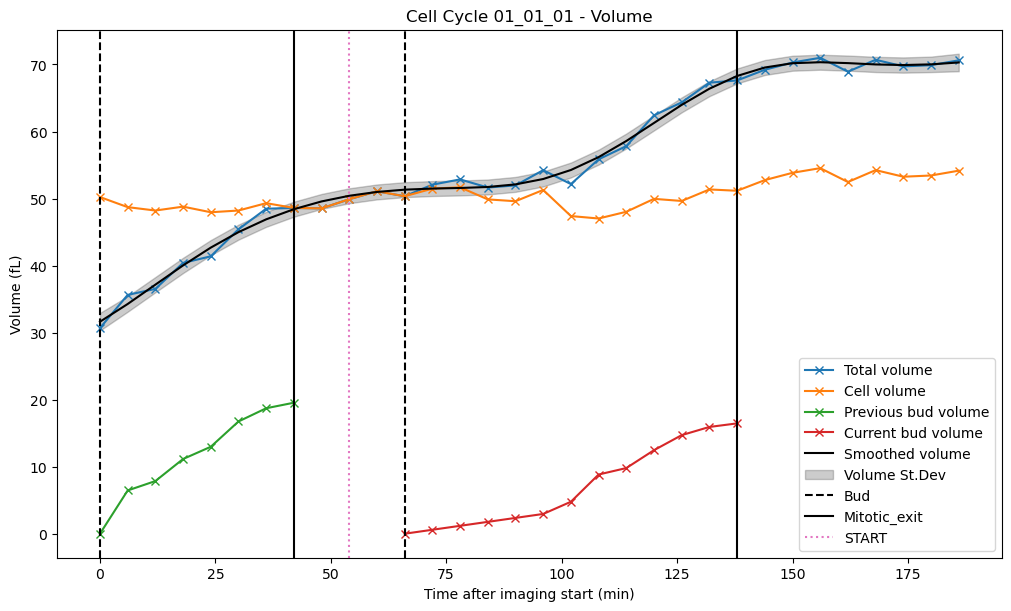

In [15]:
vol_plot = cc.plot("Volume")

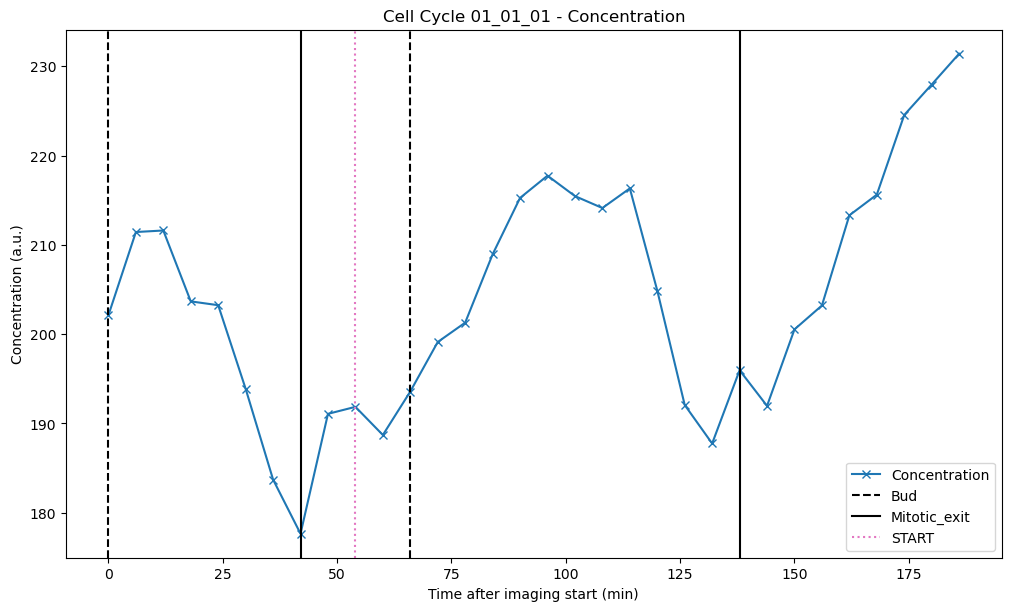

In [16]:
conc_plot = cc.plot("Concentration")

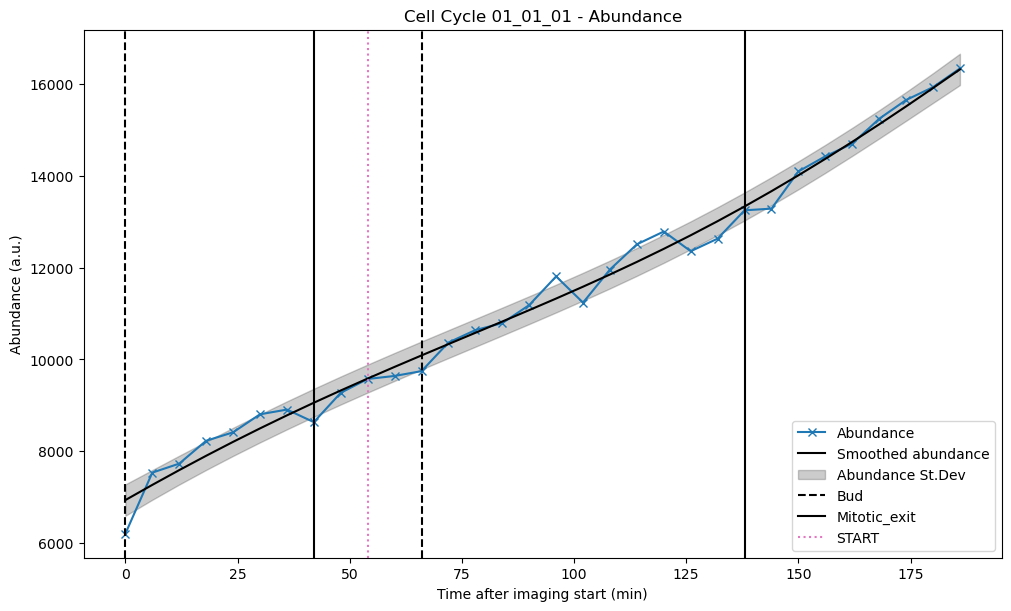

In [17]:
abundance_plot = cc.plot("Abundance")

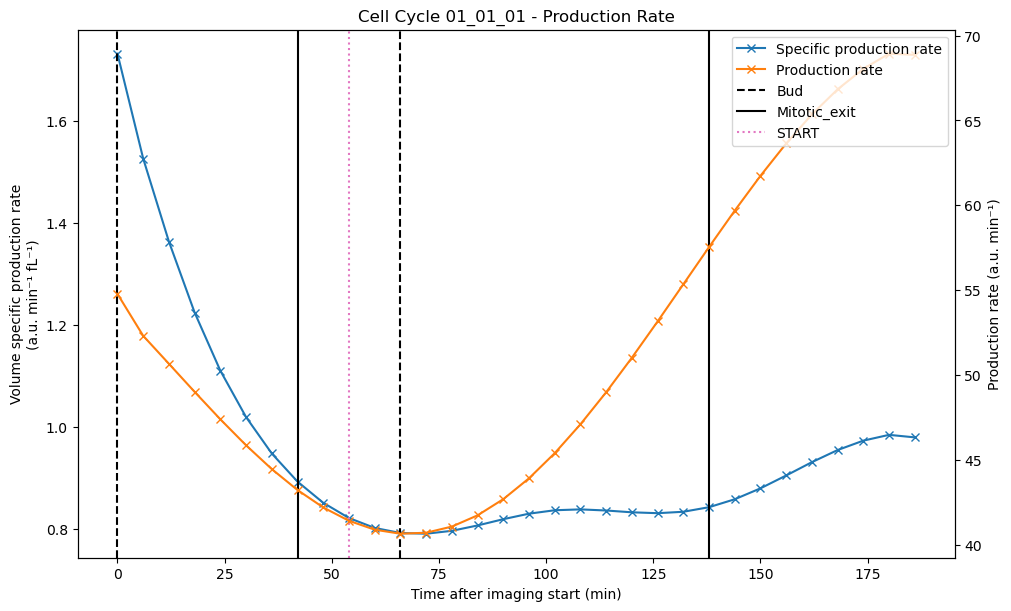

In [18]:
production_rate_plot = cc.plot("Production rate")

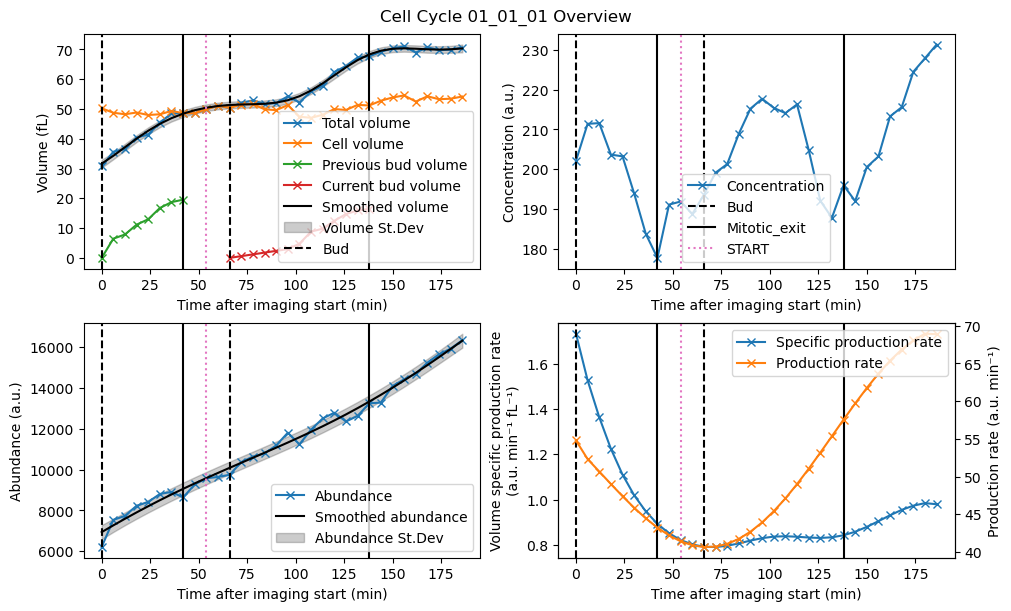

In [19]:
overview_plot = cc.plot("Overview")

## The `FluorescentProteinProductionRateExperiment` class

This class contains a collection of `CellCycle` instances and you can use this to coordinate the analysis of multiple cell cycles all in one go. Once you have calculated all the relevant values for each cycle, this class handles mapping the data to a standard cell cycle progression coordinate and then fitting a GP to the volume specific production rate.

### Creating a `FluorescentProteinProductionRateExperiment` instance

In [20]:
experiment = FluorescentProteinProductionRateExperiment(
    experiment_id="Test Experiment",
    image_capture_interval=6,
    cycle_end_event="Mitotic_exit",
    min_extra_data_points=3,
    max_extra_data_points=8
)

### Adding cell cycle data

Add a bunch of cell cycles to the experiment.

In [ ]:
for cell_id in cell_ids:
    experiment.add_cell_cycle(
        cell_id,
        mother_data=old_cell_test_data[cell_id]["mother_data"],
        previous_bud_data=old_cell_test_data[cell_id]["previous_bud_data"],
        current_bud_data=old_cell_test_data[cell_id]["current_bud_data"],
        cycle_events=old_cell_test_data[cell_id]["cycle_events"]
    )

### Operating on individual cell cycles

You can get the `CellCycle` instance for a given cycle from it's cycle ID in two ways:

In [22]:
print(experiment["01_01_01"])
print(experiment.get_cell_cycle("01_01_01"))

'CellCycle': '01_01_01', 'Merged': False, 'Abundance': False, 'Smoothed abundance': False, 'Production rate': False, 'Smoothed volume': False, 'Specific production rate': False
'CellCycle': '01_01_01', 'Merged': False, 'Abundance': False, 'Smoothed abundance': False, 'Production rate': False, 'Smoothed volume': False, 'Specific production rate': False


Or iterate over all the cycles in the experiment:

In [23]:
for cycle in experiment:
    print(cycle.cycle_id)

01_01_01
01_01_02
01_02_01
02_01_01
02_01_02
02_02_01
02_02_02
02_03_01
02_03_02
02_03_03
02_04_01
02_04_02
04_01_01
04_01_02
04_02_01
04_03_01
04_04_01
04_04_02
05_01_01
05_02_01


### Batch processing of cell cycles

You can perform all of the individual `CellCycle` analysis steps as batch processes for all the cycles in the experiment at once using the same-named methods on the `FluorescentProteinProductionRateExperiment` class. This will call the corresponding methods on each `CellCycle` instance in turn.

In [24]:
experiment.merge_cycle_data()
experiment["01_01_01"].cycle_data.head()

,TimeID,Volume,Concentration,Previous bud volume,Current bud volume,Total volume,Time
1,1,50.224642,202.121662,-19.543974,0.0,30.680668,0
2,2,48.719748,211.432678,-13.092713,0.0,35.627035,6
3,3,48.213080,211.605422,-11.688383,0.0,36.524697,12
4,4,48.793960,203.664179,-8.398231,0.0,40.395729,18
5,5,47.957459,203.236006,-6.572128,0.0,41.385331,24


Again, you can chain the methods together or just call `.calculate_all_cycle_values()` to do everything in one go.

In [ ]:
(
    experiment.merge_cycle_data()
    .calculate_abundance()
    .calculate_smoothed_abundance()
    .calculate_production_rate(apply_maturation_correction=True, maturation_time=6)
    .calculate_smoothed_volume()
    .calculate_volume_specific_production_rate()
)

# Or, alternatively use the convenience method. Note that any arguments to be passed to
# the `calculate_smoothed_abundance`, `calculate_production_rate`, and
# `calculate_smoothed_volume` methods need to be passed as dictionaries.
experiment.calculate_all_cycle_values(
    calculate_production_rate_kwargs={
        "apply_maturation_correction": True,
        "maturation_time": 6
    }
)

### Aligning cell cycles onto a standard cell cycle coordinate

Once you've performed those calculations for each cell cycle, it's time to align them onto a standard cell cycle coordinate. The only essential argument for this is `cell_cycle_anchors` which should be a sequence of the names of the events that you want to use as 'anchor' points when mapping data from the time domain to the cell cycle coordinate. It's up to you to ensure that the ordering of these events makes sense.

In [26]:
experiment.calculate_standard_coordinate_anchors(("Mitotic_exit_0", "START", "Bud_1", "Mitotic_exit_1"))

# You can then see the anchor points if you wish.
experiment.standard_coordinate_anchors

{'Mitotic_exit_0': np.float64(0.0),
 'START': np.float64(0.11185935474054672),
 'Bud_1': np.float64(0.2830284917610769),
 'Mitotic_exit_1': np.float64(1.0)}

Next, align the cycles and extract one large DataFrame containing all of the aligned cell cycle data for all the cycles.

In [27]:
experiment.align_to_standard_coordinate().extract_aligned_cycle_data()

experiment.aligned_cycle_data.head()

TimeID     Volume  Concentration  Previous bud volume  \
01_01_01 8        8  48.600334     177.639098                  0.0   
         9        9  48.532949     191.065967                  0.0   
         10      10  49.903223     191.850370                  0.0   
         11      11  51.086699     188.697708                  0.0   
         12      12  50.342975     193.568543                  0.0   

             Current bud volume  Total volume  Time    Abundance  \
01_01_01 8                  0.0     48.600334    42  8633.319416   
         9                  0.0     48.532949    48  9272.994749   
         10                 0.0     49.903223    54  9573.951875   
         11                 0.0     51.086699    60  9639.942991   
         12                 0.0     50.342975    66  9744.816314   

             Smoothed abundance  Abundance std  Production rate  \
01_01_01 8          9056.019615     305.538239        43.226000   
         9          9323.174158     305.483841        42.200058   
         10         9583.253920     305.244644        41.412546   
         11         9837.483587     304.857996        40.889572   
         12        10087.271497     304.399274        40.650868   

             Smoothed volume  Volume std  Specific production rate  \
01_01_01 8         48.414656    1.117983                  0.892829   
         9         49.571480    1.116944                  0.851297   
         10        50.415460    1.115247                  0.821426   
         11        50.986953    1.114281                  0.801961   
         12        51.326292    1.114151                  0.792009   

             Standard coordinate  
01_01_01 8              0.000000  
         9              0.055930  
         10             0.111859  
         11             0.197444  
         12             0.283028

### Fitting a Gaussian Process to the volume specific production rate

Lastly, you can fit the GP and plot the output!

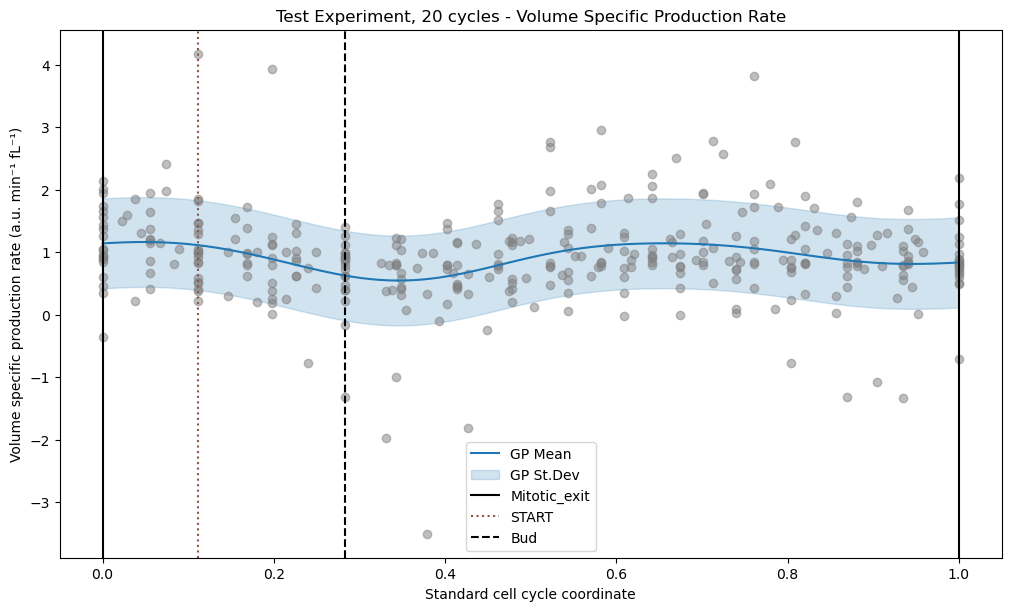

In [28]:
experiment.fit_specific_production_rate_gp(n_restarts=5, random_seed=101)
rate_plot = experiment.plot_specific_production_rate()

### Filtering cycles within a `FluorescentProductionRateExperiment`

It is possible to filter a `FluorescentProductionRateExperiment` such that you obtain a new object of the same type which only contains cycles which satisfy some condition. 

To do this, first define a function which takes a `CellCycle` instance argument and returns a boolean indicating whether the cycle should be included or not. Then call the `filter_cycles()` method on the `FluorescentProductionRateExperiment` instance, passing in the function.

In [29]:
# Function which returns True if a cycle begins after frame 10.
def begin_frame_filter(cycle: CellCycle):
    return cycle.previous_cycle_end_time_id > 10

# Perform the filtering
filtered_experiment = experiment.filter_cycles(begin_frame_filter)
print(
    f"experiment has {len(experiment)} cycles, whereas "
    f"filtered_experiment only has {len(filtered_experiment)}"
)

experiment has 20 cycles, whereas filtered_experiment only has 19


You can also use a filter function which takes more than one argument by providing the additional arguments to `.filter_cycles`.

In [30]:
# Function which returns True if a cycle's duration is between two user specified values
def cycle_duration_between(cycle: CellCycle, min_duration: float, max_duration: float):
    return min_duration <= cycle.cycle_duration <= max_duration

filtered_experiment2 = experiment.filter_cycles(cycle_duration_between, 90, 120)
print(
    f"experiment has {len(experiment)} cycles, whereas "
    f"filtered_experiment2 only has {len(filtered_experiment2)}"
)

experiment has 20 cycles, whereas filtered_experiment2 only has 16


Note that, after filtering, the filtered `FluorescentProteinProductionRateExperiment` will need to have all operations downstream of calculating standard cell cycle coordinates performed again.

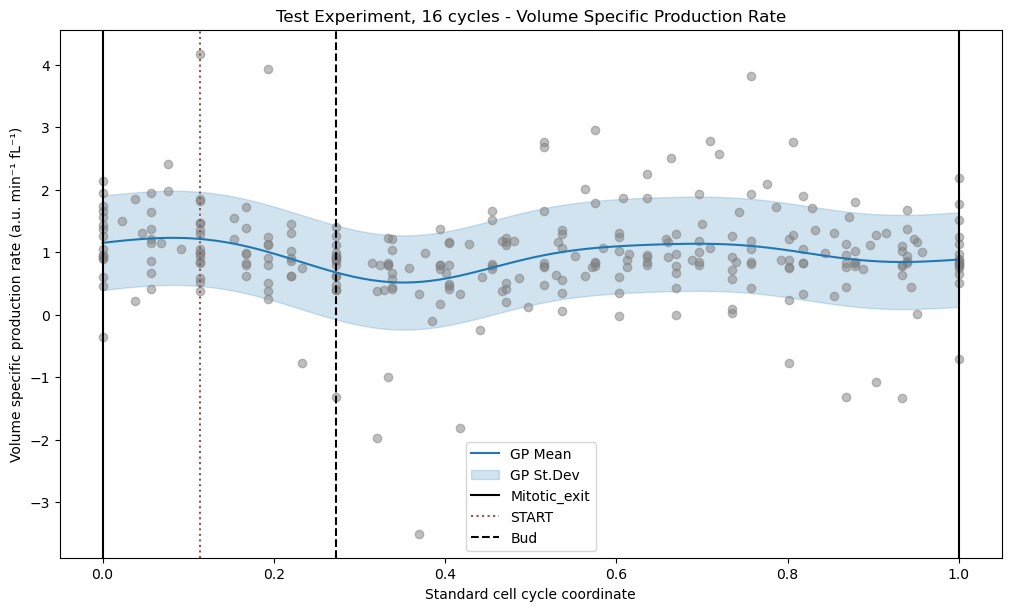

In [31]:
filtered_rate_plot = (
    filtered_experiment2
    .calculate_standard_coordinate_anchors(
        ("Mitotic_exit_0", "START", "Bud_1", "Mitotic_exit_1")
    )
    .align_to_standard_coordinate()
    .extract_aligned_cycle_data()
    .fit_specific_production_rate_gp(n_restarts=5, random_seed=101)
    .plot_specific_production_rate()
)